# Calling the simulation endpoint

We can use the endpoint `/basic/simulate` to perform simulations of an
experimental campaign. Such simulations can inform modeling and policy choices,
and provide estimates about future campaign performance. The call to this
endpoint is similar to the call to `/basic/suggest`, except we must additionally
specify a `sim_params` dictionary specifies additional parameters.

The most important thing we specify in this dictionary are **Quantities of
Interests (QOIs)**. QOIs are values that Holmes calculates at each simulation
step, and can represent campaign performance metrics. We write $Y(n)$ as some
QOI calculated at the $n$-th step of a simulation. For example, the
**Opportunity Cost (OC)** QOI measures a campaign's performance in identifying
inputs that lead to optimal responses. That is, it is a performance metric for
an optimization campaign.

By performing several simulations, we get a distribution of the QOIs. Holmes
summarizes such distribution by reporting median QOI values, along with the 33rd
and 66th percentile. By default, Holmes reports the distribution $Y(n)$ of
a QOI versus the simulation step $n$. However, we can also obtain distribution
of $Y(n)$ versus another QOI $X(n)$. Therefore, in addition to specifying
a list of QOIs, we must additionally specify which QOI serves as $Y(n)$ and
optionally which QOI serves as $X(n)$ (if not the step number $n$ itself).

Lastly, we need to specify how many simulations to perform. Here is an example
of the `sim_params` dictionary that we send in the request.

```
"sim_params": {
    "num_sims": 512,
    "qois": ["{oc}"],
    "y_qoi": "oc"
}
```

We specify the list of QOIS in the `qois` entry, which should be a list of model
references. We see that we reference the `"{oc}"` model, which is a predefined
model. If not referencing a predefined model, we must manually specify a QOI
model in `model_specs` dictionary like any other model. We also specify that
this OC QOI should serve as the $Y(n)$ QOI that we report versus the step number
$n$.

The number of steps a simulation executes is determined by the feasibility
model. Simulations start of from a prior state defined in the `state` model
and proceed until no more feasible actions are available. The default
feasibility model specifies a fixed number of actions. We can specify this
number through the `action_budget` parameter in `model_specs`.

Lastly, simulations are run for every policy in the `policies` list. We can
therefore use such simulations to compare policies.

All simulations are **truth-from-prior** simulations. That is, when we simulate
responses from the ground truth (which we normally obtain from running
real-world experiments/actions), we simply simulate from a synthetic ground
truth. This ground truth is sampled from the prior state, that is defined by
the state model and any data used to define that state. This prior state is
also the starting state for all simulations. That is, you should interpret
simulations as predictions of what could happen **now**, starting with the
data/prior assumptions you already have (or pass to the simulation endpoint).

Below, we run simulations from a pure prior state, without data. Instead
of specifying data, we simply specify the meta-data for the data in
`type_specs`. From this prior state, we compare the performance for several
policies using the OC metric:

In [17]:
request = {
    "model_specs": {
        "state": {
            "name": "holmes.state.GPBeliefState",
            "params": {
                "data[as_action_obs_data]":
                    { "actions": "{action_type}", "obs": "{obs_type}" }
            } },

        "action_budget": 8
    },

    "sim_params": { "num_sims": 512, "qois": ["{oc}"], "y_qoi": "oc" },
    "policies": [ "{xplr}", "{xplt}", "{gpei}", "{mcei}", "{maxvar}"],

    "type_specs": {
        "action_type": {
            "name": "holmes.data_types.UnitBoundedData",
            "params": {"dim": 1}},
        "obs_type": {
            "name": "holmes.data_types.StandardNormalData",
            "params": {"dim": 1}},
    }
}

Having defined the request, we send it to the `/basic/simulate` endpoint.
Currently, this endpoint is **blocking**. That is, the endpoint doesn't return
a response until the simulations are all completed. This behavior will change
in future iterations of Holmes server, and will be replaced with asynchronous
calls to initiate the simulations and separate calls to retrieve simulation
results.

For now, we just wait for the response, which can take some time if
the `num_sims`, `exp_budget`, or the number of policies in `policies` is
large.

In [18]:
import requests
BASE_URL = "http://127.0.0.1:5000/holmes"

# These simulation requests take a long time and block return
res = requests.post(BASE_URL + "/basic/simulate", json = request).json()

The `sim_res` entry in `res` contains the simulation results, organized by
policy. This entry is an array with the same number of  entries as policies.
Thus `res['sim_res'][i]` holds the simulation results for the `i`-th policy
(although there is no guarantee that the order is preserved). This entry is a
dictionary:

* `res['sim_res'][i]['policy']` is a string containing the name of the `i`-th
  policy.
* `res['sim_res'][i]['qoi_dist']` holds summary statistics of the QOI $Y(n)$
versus the QOI $X(n)$:
    * `res['sim_res'][i]['qoi_dist']['x_qoi']` holds a sorted list of the
       discrete QOI values of $X(n)$.
    * `res['sim_res'][i]['qoi_dist']['md']` holds a sorted list of the
       median values of $Y(n)$ for each value of $X(n)$.
    * `res['sim_res'][i]['qoi_dist']['lo']` holds a sorted list of the
       33rd percentile of $Y(n)$ for each value of $X(n)$.
    * `res['sim_res'][i]['qoi_dist']['lo']` holds a sorted list of the
       66th percentile of $Y(n)$ for each value of $X(n)$.

We can use these quantities to visualize the QOI. Below we plot this
distribution of the OC QOI versus the number of steps (the default $X(n) = n$).

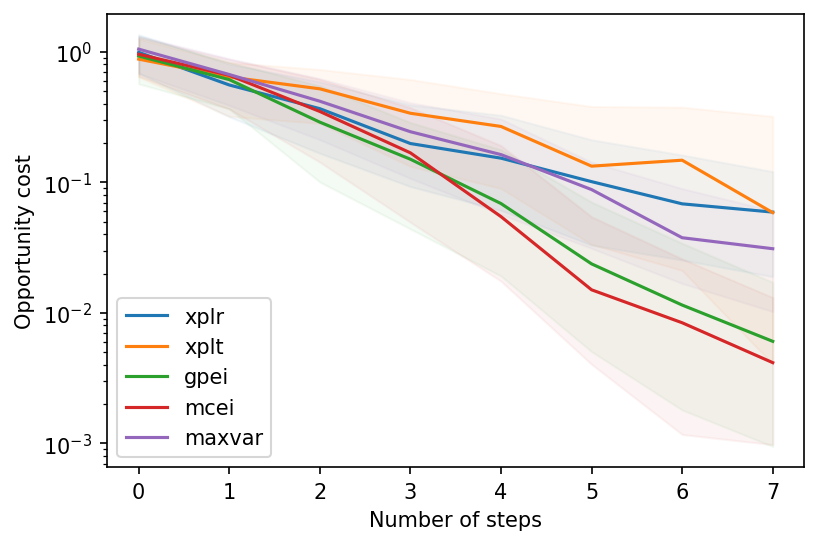

In [19]:
import matplotlib.pyplot as plt

all_sim_res = res['sim_res']

plt.figure(dpi=150, facecolor = 'w')

# Loop over the simulation results for each policy
for sim_res in all_sim_res:
    policy = sim_res['policy']
    x = sim_res['qoi_dist']['x_qoi']
    lo = sim_res['qoi_dist']['lo']
    md = sim_res['qoi_dist']['md']
    hi = sim_res['qoi_dist']['hi']

    # plot median values
    h = plt.plot(x, md, label = policy)
    # plot low and high envelope
    plt.fill_between(x, lo, hi, color = h[0].get_color(), alpha=0.05)
    plt.xlabel('Number of steps')
    plt.ylabel('Opportunity cost')
    plt.yscale('log')

plt.legend()

From these **OC Curves**, we can fit a exponential decay rate model
$OC(t) = A \exp[-kt]$. The decay rate $k$ is a measure of how fast a campaign
learns optimal value, with larger values reflecting better optimization.

Below, we fit each of the median OC curves to such a decy model and calculate
the decay rate.

In [20]:
import numpy as np

print("%10s | %4s"%("Policy", "Decay Rate"))
print("-"*26)

for sim_res in all_sim_res:
    policy = sim_res['policy']
    x = sim_res['qoi_dist']['x_qoi']
    md = np.array(sim_res['qoi_dist']['md'])

    # fit exponential decay log(oc) = -k t + b -> oc = A exp(-kt), A = e^b
    y = np.log(md + 1e-6)
    Phi = np.array([np.ones(len(y)), x]).T
    decay_rate = -1.0* np.linalg.lstsq(Phi, y, rcond=None)[0][1]

    print("%10s : %4.2f"%(policy, decay_rate))

    Policy | Decay Rate
--------------------------
      xplr : 0.41
      xplt : 0.36
      gpei : 0.75
      mcei : 0.84
    maxvar : 0.53


From this, we see that the GP-EI and MC-EI policy are best, while pure
exploitation (XPLT) is worst.